<a href="https://colab.research.google.com/github/jotix16/PGM/blob/master/Tutorial8/Variational_Bayes_for_simple_multivariate_Gau%C3%9Fian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# author Olga Mikheeva olgamik@kth.se
# PGM tutorial on Variational Inference
# Bayesian Mixture of Gaussians

import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
def generate_data(std, k, n, dim=1):
    means = np.random.normal(0.0, std, size=(k, dim))
    data = []
    categories = []
    for i in range(n):
        cat = np.random.choice(k)  # sample component assignment
        categories.append(cat)
        data.append(np.random.multivariate_normal(means[cat, :], np.eye(dim)))  # sample data point from the Gaussian
    return np.stack(data), categories, means

In [202]:
def plot(x, y, c, means, title):
    plt.scatter(x, y, c=c)
    plt.scatter(means[:, 0], means[:, 1], c='r')
    plt.title(title)
    plt.show()


def plot_elbo(elbo):
    plt.plot(elbo)
    plt.title('ELBO')
    plt.show()


def compute_elbo(data, psi, m, s2, sigma2, mu0):
    """ Computes ELBO
    :param data: data where each row is a sample
    :param psi: rows are parameters of categorical distributions for each sample in data
    :param m: matrix with means for each mixture in each row
    :param s2: variances for each mixture
    :param sigma2: variance of mean prior (same for all mixtures)
    :param mu0: mean of mean prior (same for all mixtures)
    :return elbo
    """
    n, p = data.shape
    k = m.shape[0]
    lamda = 1
    elbo = 0
    ## compute ELBO

    # expected log prior over mixture assignments
    a_2 = -n*np.log(k)

    # expected log prior over mixture locations
    a_1 = -0.5*k*(np.log(2*np.pi*sigma2)-np.dot(mu0,mu0)/sigma2) \
          +np.dot(mu0,np.sum(m,0))/sigma2 - 0.5*sum(np.dot(m[j,:],m[j,:])+2*s2[j] for j in range(m.shape[0]))/sigma2
                                                 
    # expected log likelihood
    sum_psi =np.sum(psi,0) 
    a_3 = -0.5*n*np.log(2*np.pi*lamda) - 0.5/lamda*(sum(np.dot(x_i,x_i) for x_i in data)) \
          + sum( np.dot(m[j,:], np.sum(psi[:,j].reshape(n,1)*data,0)) for j in range(k) ) \
          - 0.5/lamda* sum(2*s2[j] + np.dot(m[j,:],m[j,:])*sum_psi[j] for j in range(k)  )

    # entropy of variational location posterior
    a_4 = -k/2 - 0.5*np.sum(np.log(2*np.pi*s2))

    # entropy of the variational assignment posterior
    a_5 = np.piecewise(psi, [psi == 0, psi > 0], [0, np.log])
    a_5 = np.sum(np.multiply(a_5,psi))
    
    return a_1+a_2+a_3+a_4+a_5

In [252]:
def cavi(data, k, sigma2, m0, eps=1e-15):
    """ Coordinate ascent Variational Inference for Bayesian Mixture of Gaussians
    :param data: data
    :param k: number of components
    :param sigma2: prior variance
    :param m0: prior mean
    :param eps: stopping condition
    :return (m_k, s2_k, psi_i)
    """
    n, p = data.shape
    lamda = 1.0
    # initialize randomly
    m = np.random.normal(0., 1., size=(k, p))
    s2 = np.square(np.random.normal(0., 1., size=(k)))
    psi = np.random.dirichlet(np.ones(k), size=n)

    # compute ELBO
    elbo = [compute_elbo(data, psi, m, s2, sigma2, m0)]
    convergence = 1.0
    while (convergence > eps):  # while ELBO not converged
        # update categorical
        x = 0.5*(2*s2.reshape(1,k)+np.array([np.dot(m[j,:],m[j,:]) for j in range(m.shape[0])]))/lamda      
        data2=data.dot(np.transpose(m))/lamda
        psi = np.exp( np.add(data2,-x) )
        
        # normalize psi
        row_sums = psi.sum(axis=1)
        psi = psi / row_sums[:, np.newaxis]

      
        # update posterior parameters for the component means
        s2 = 1/( 1/sigma2 + np.sum(psi,0) ) # update sigmas      
        
        m = np.transpose(psi).dot(data) * s2[:,np.newaxis] # update means
        
        # compute ELBO
        elbo.append(compute_elbo(data, psi, m, s2, sigma2, m0))
        convergence = elbo[-1] - elbo[-2]

    return m, s2, psi, elbo

-1770.9069852154655 -1770.8980050324833


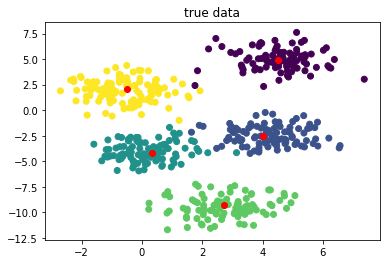

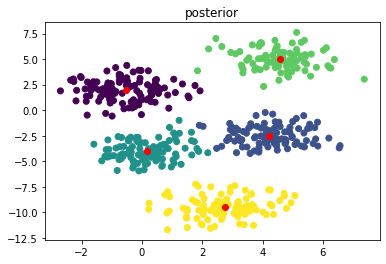

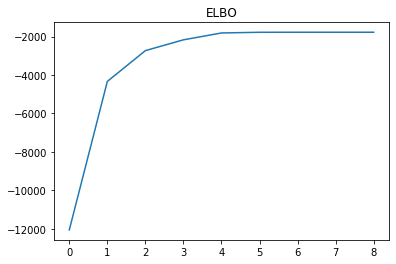

In [261]:
# parameters
p = 2
k = 5
sigma = 5.

data, categories, means = generate_data(std=sigma, k=k, n=500, dim=p)
m = list()
s2 = list()
psi = list()
elbo = list()
best_i = 0

for i in range(10):
    m_i, s2_i, psi_i, elbo_i = cavi(data, k=k, sigma2=sigma**2, m0=np.zeros(p))
    m.append(m_i)
    s2.append(s2_i)
    psi.append(psi_i)
    elbo.append(elbo_i)
    if i > 0 and elbo[-1][-1] > elbo[best_i][-1]:
        best_i = i
print(elbo[-1][-1] ,elbo[best_i][-1])        
class_pred = np.argmax(psi[best_i], axis=1)
plot(data[:, 0], data[:, 1], categories, means, title='true data')
#print(psi)
plot(data[:, 0], data[:, 1], class_pred, m[best_i], title='posterior')
plot_elbo(elbo[best_i])

